In [43]:
import requests
import pandas as pd
import json
import geopandas as gpd
from sodapy import Socrata

In [79]:
socrata_domain = "data.lacity.org"
id = "d5tf-ez2w"

In [77]:
client = Socrata(socrata_domain, "jEqnFj2BvLJwBvLPURiPkUNOh ", timeout=100)


In [72]:
len(client.datasets())

1069

In [121]:

query = """
SELECT
  *
WHERE
  ((`date_occ` > "2022-01-01T00:00:00" :: floating_timestamp)
     AND contains(`mocodes`, "3003"))
    OR ((`date_occ` > "2022-01-01T00:00:00" :: floating_timestamp)
          AND contains(`mocodes`, "3008"))
LIMIT 
    10000
"""

query2 = """
SELECT
  *
WHERE
  ((`date_occ`
      BETWEEN "2022-01-01T00:00:00" :: floating_timestamp
      AND "2022-12-31T23:21:35" :: floating_timestamp)
     AND contains(`mocodes`, "3003"))
    OR ((`date_occ`
           BETWEEN "2022-01-01T00:00:00" :: floating_timestamp
           AND "2022-12-31T23:21:52" :: floating_timestamp)
          AND contains(`mocodes`, "3008"))
LIMIT 
    10000
"""

results = client.get(id, query=query)
results_df = pd.DataFrame.from_records(results)

print(len(results_df))
results_df.head()



2860


,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,location,cross_street,location_1
0,221004028,2022-01-02T00:00:00.000,2022-01-02T00:00:00.000,0850,10,West Valley,1023,997,TRAFFIC COLLISION,3003 3026 4026 3029 3036 3101,35,M,H,101,STREET,SHERMAN WY,WILBUR AV,"{'latitude': '34.2011', 'longitude': '-118.544..."
1,220104093,2022-01-02T00:00:00.000,2022-01-02T00:00:00.000,1610,01,Central,0111,997,TRAFFIC COLLISION,3401 3701 0605 3008 3026 3029 3101 4024,66,M,H,101,STREET,ALPINE ST,BROADWAY,"{'latitude': '34.0624', 'longitude': '-118.238..."
2,220604081,2022-01-03T00:00:00.000,2022-01-02T00:00:00.000,2000,06,Hollywood,0657,997,TRAFFIC COLLISION,3003 3029 4027 3035 3037 3101 3401 3701 1218 3024,69,M,W,101,STREET,WESTERN AV,ROMAINE ST,"{'latitude': '34.0885', 'longitude': '-118.309..."
3,220804107,2022-01-04T00:00:00.000,2022-01-03T00:00:00.000,1040,08,West LA,0858,997,TRAFFIC COLLISION,3003 3024 3035 3036 3101 3701 4027 3401,50,M,O,101,STREET,PICO BL,ROBERTSON BL,"{'latitude': '34.0549', 'longitude': '-118.384..."
4,220304077,2022-01-03T00:00:00.000,2022-01-03T00:00:00.000,0150,03,Southwest,0394,997,TRAFFIC COLLISION,3003 3026 4025 3029 3038,59,F,B,101,STREET,VERNON AV,5TH AV,"{'latitude': '34.0037', 'longitude': '-118.322..."


<AxesSubplot:>

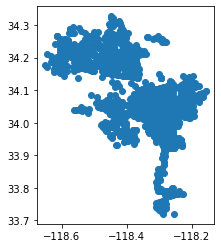

In [122]:
gdf = gpd.GeoDataFrame(results_df, geometry = gpd.points_from_xy(results_df.location_1.str['longitude'], results_df.location_1.str['latitude']))

gdf.plot()

In [123]:
cd4 = gpd.read_file("CD4.geojson")
gdf = gdf.set_crs(epsg=4326)

cd4_collisions = gpd.sjoin(gdf, cd4, predicate='within')
len(cd4_collisions)

ERROR:fiona._env:PROJ: internal_proj_create_from_database: /Users/hfrahn/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR:fiona._env:PROJ: internal_proj_identify: /Users/hfrahn/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


121

<AxesSubplot:>

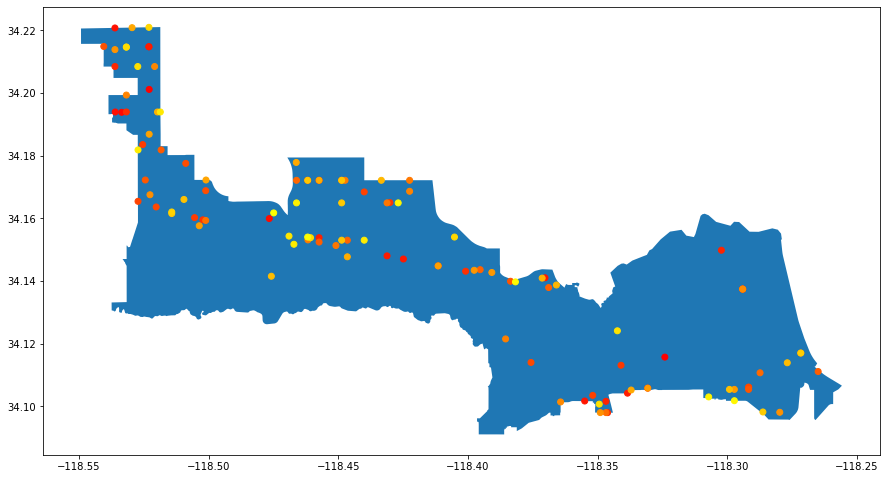

In [124]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 15))
cd4.plot(ax=ax)
cd4_collisions.plot(ax=ax, column = "date_occ", cmap = "autumn")

In [147]:
cd4_collisions.columns

Index(['dr_no', 'date_rptd', 'date_occ', 'time_occ', 'area', 'area_name',
       'rpt_dist_no', 'crm_cd', 'crm_cd_desc', 'mocodes', 'vict_age',
       'vict_sex', 'vict_descent', 'premis_cd', 'premis_desc', 'location',
       'cross_street', 'location_1', 'geometry', 'index_right', 'dist_name',
       'district', 'name', 'objectid', 'year'],
      dtype='object')

In [148]:
cd4_collisions['year'] = cd4_collisions.date_occ.str.slice(start = 0, stop = 4)
cd4_collisions.year
cd4_collisions = cd4_collisions.rename(columns={"date_occ": "Date Occurred", "time_occ": "Time Occurred", "vict_age": "Victim Age", "vict_sex": "Victim Sex", "mocodes": "MO Codes"})

In [149]:
split = list(cd4_collisions.groupby("year"))
len(split)

2

In [153]:
for df in split: 
    name = df[0]+"collisions.geojson"
    df[1].to_file(name, driver = "GeoJSON")